# Analysis and comparison of different spectral clustering implementations
<pre>
Source publication for dataset: 
https://www.nature.com/articles/s41467-018-02866-0
TODO
References:
</pre>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hypernetx as hnx
import model
import utils

# Initialization

In [2]:
cell_count = 456
gene_count = 100
infile_dir = "./../data/TEsmESC/"

m = model.HyperGraph(n_cells=cell_count, n_genes=gene_count, infile_dir=infile_dir)


# Graph Construction

In [3]:
m.construct_graph(0.95)
m.prune_graph()

# Visualizing TE scores across cells (over time)

In [4]:
# heat_fig = sn.heatmap(PWscores[0, :, :], square=True)
    # as_file = heat_fig.get_figure()
    # path = "./../out/cell{i}.png".format(i = i + 1)
    # as_file.savefig(path)
    # ax.tick_params(left=False, bottom=False)

# Hypergraph Visualization

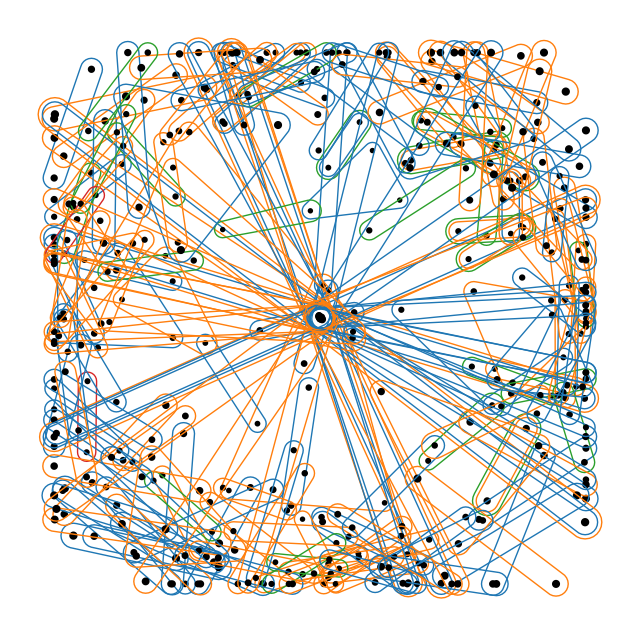

In [5]:
# plt.figure(dpi=360)
# plt.savefig("./hgraphsmall")
utils.visualize_hyperedge_set(m)

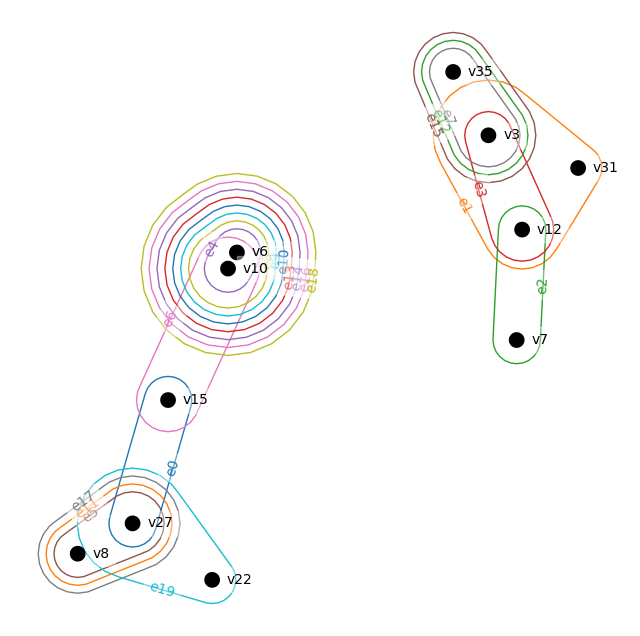

In [6]:
H_test = hnx.classes.Hypergraph.from_numpy_array(M = m.H[:, 60:80])
hnx.drawing.rubber_band.draw(H_test)

# Forming the graph Laplacian

In [7]:
m.set_graph_Laplacian()

In [14]:
# m.L.shape
m.n_genes

36

# From *On Spectral Clustering: Analysis and an algorithm*

From L-normal:
1. Find k **largest** orthogonal eigen*vectors* (orthogonal to avoid vecs of repeated eigen*values*) of L
2. Make a matrix of 'em, n_genes x k = X
3. Y = Normalize each row of X to have unit length
4. Treat each row of Y as a point in R<sup>k</sup>, cluster into k-clusters via kmeans
5. Assign rows i (you can just use the gene labels vector) to cluster j iff row i in Y was assigned to cluster j 



In [8]:
sorted_eigvals, sorted_eigvecs = m.get_sorted_eigens()

# Visualizing Eigenvalues for Hyperparameter Selection

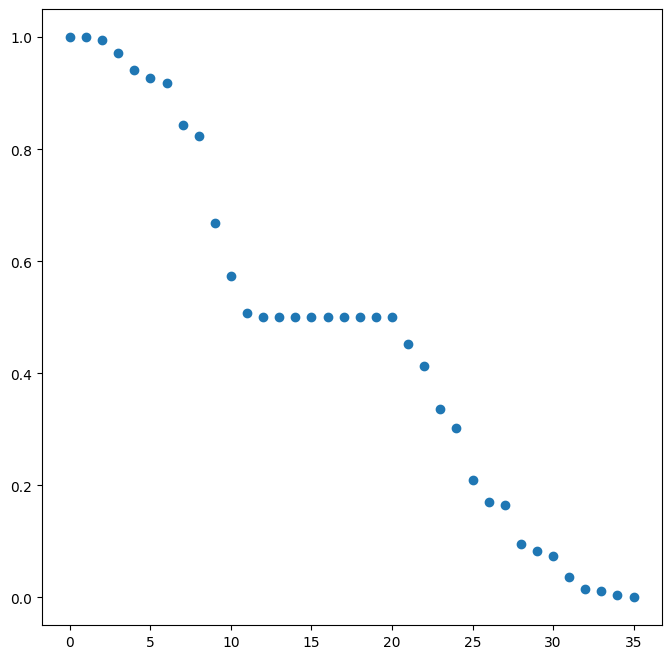

In [9]:
x = np.arange(m.n_genes)
plt.scatter(x, sorted_eigvals)

# Perform the clustering to determine the pathways

In [10]:
clusters = utils.get_clusters(5, sorted_eigvecs, m.gene_labels, 3)

In [11]:
# TODO: analyze what's in the clusters proper
for c in clusters:
    print(c)
    print("\n")

['SOX2' 'EPAS1' 'FOXQ1' 'KLF2' 'GATA4' 'SOX17' 'ZFP42' 'POU5F1' 'DNMT3A'
 'ELF3' 'NANOG' 'CREB3L2' 'FOXH1' 'NFXL1' 'RBPJ' 'KDM5B' 'BHLHE40' 'BMP2'
 'CREB3' 'SIX1' 'ZBTB10' 'XBP1' 'MSC' 'GATA6' 'HNF1B' 'KLF3' 'DNMT3L'
 'TBX3' 'FOXD3' 'MYBL2' 'NFIL3' 'HNRNPK' 'ELF2' 'SALL4']




# Analysis with hnx package

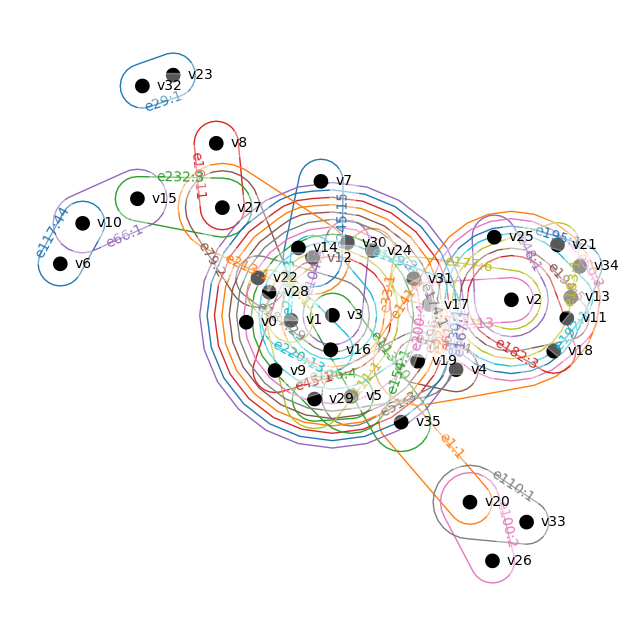

In [12]:
HG = utils.get_unweighted_graph(m.H)
hnx.drawing.rubber_band.draw(HG)